**Imports des bibliothèques nécessaires**

In [1]:
# pip install numpy pandas scikit-learn matplotlib seaborn

In [2]:
import pandas as pd 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import operator
from datetime import datetime
import joblib
import os

print("Bibliothèques importées avec succès")

Bibliothèques importées avec succès


**Charger les datasets de la CAN**

In [3]:
matches = pd.read_csv('Africa Cup of Nations Matches.csv')
players = pd.read_csv('Africa Cup of Nations Players.csv')
champions = pd.read_csv('Champions.csv')
team_stats = pd.read_csv('General Statistics For each Participated Team.csv')

matches.head()

,Year,Date,Time,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,Stage,SpecialWinConditions,Stadium,City,Attendance
0,1957,10-Feb-57,NaN,Sudan,Egypt,1.0,2.0,Semifinals,NaN,Municipal Stadium,Khartoum,30000.0
1,1957,10-Feb-57,NaN,Ethiopia,South Africa,NaN,NaN,Semifinals,Ethiopia wins due to disqualification of othe...,NaN,NaN,NaN
2,1957,16-Feb-57,NaN,Egypt,Ethiopia,4.0,0.0,Final,NaN,Municipal Stadium,Khartoum,30000.0
3,1959,22-May-59,NaN,Egypt,Ethiopia,4.0,0.0,Final Tournament,NaN,Prince Farouk Stadium,Cairo,30000.0
4,1959,25-May-59,NaN,Sudan,Ethiopia,1.0,0.0,Final Tournament,NaN,Prince Farouk Stadium,Cairo,20000.0


In [4]:
print(f"Matches chargés: {matches.shape}")
print(f"Joueurs chargés: {players.shape}")
print(f"Champions chargés: {champions.shape}")
print(f"Statistiques équipes: {team_stats.shape}")
print("\nColonnes:", matches.columns.tolist())
print("\nInfo:")
print(matches.info())

Matches chargés: (674, 12)
Joueurs chargés: (8197, 10)
Champions chargés: (33, 2)
Statistiques équipes: (44, 11)

Colonnes: ['Year', 'Date ', 'Time ', 'HomeTeam', 'AwayTeam', 'HomeTeamGoals', 'AwayTeamGoals', 'Stage', 'SpecialWinConditions', 'Stadium', 'City', 'Attendance']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  674 non-null    int64  
 1   Date                  674 non-null    object 
 2   Time                  385 non-null    object 
 3   HomeTeam              674 non-null    object 
 4   AwayTeam              674 non-null    object 
 5   HomeTeamGoals         670 non-null    float64
 6   AwayTeamGoals         670 non-null    float64
 7   Stage                 674 non-null    object 
 8   SpecialWinConditions  62 non-null     object 
 9   Stadium               670 non-null    object 
 

**Préparation des données**

In [5]:
print("\nNoms des colonnes dans le dataset des matches:")
print(matches.columns.tolist())
# Normaliser les noms de colonnes (enlever les espaces, mettre en minuscule)
matches.columns = matches.columns.str.strip()

# Mapper les noms de colonnes vers des noms standards
column_mapping = {
    'Date': 'date',
    'Date ': 'date',  # Au cas où il y a un espace
    'HomeTeam': 'home_team',
    'AwayTeam': 'away_team',
    'HomeTeamGoals': 'home_score',
    'AwayTeamGoals': 'away_score',
    'Stage': 'tournament',
    'City': 'city',
    'Year': 'year'
}

# Renommer les colonnes qui existent
for old_name, new_name in column_mapping.items():
    if old_name in matches.columns:
        matches.rename(columns={old_name: new_name}, inplace=True)

print("\n Colonnes renommées:")
print(matches.columns.tolist())

# Convertir la colonne date en datetime
if 'date' in matches.columns:
    matches['date'] = pd.to_datetime(matches['date'], errors='coerce')
    print(f"\n Dates converties")
else:
    print("\n ERREUR: Colonne 'date' non trouvée après renommage!")
    print(f"Colonnes disponibles: {matches.columns.tolist()}")

# Vérifier la colonne year
if 'year' in matches.columns:
    matches['year'] = matches['year'].astype(int)
else:
    # Extraire l'année de la date si nécessaire
    matches['year'] = matches['date'].dt.year
    print(" Année extraite de la date")

print(f"Période des données: {matches['date'].min()} à {matches['date'].max()}")


Noms des colonnes dans le dataset des matches:
['Year', 'Date ', 'Time ', 'HomeTeam', 'AwayTeam', 'HomeTeamGoals', 'AwayTeamGoals', 'Stage', 'SpecialWinConditions', 'Stadium', 'City', 'Attendance']

 Colonnes renommées:
['year', 'date', 'Time', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament', 'SpecialWinConditions', 'Stadium', 'city', 'Attendance']

 Dates converties
Période des données: 1976-02-29 00:00:00 à 2074-03-14 00:00:00


**Filtrage des données récentes**

In [6]:
matches_recent = matches[matches['year'] >= 2000].reset_index(drop=True)

print(f"\n Matches depuis 2000: {matches_recent.shape[0]} matches")
print(f"Tournois inclus: {sorted(matches_recent['year'].unique())}")

# Si on a encore trop peu de données, prendre tout
if len(matches_recent) < 200:
    print(f" Peu de données depuis 2000, utilisation de tout l'historique")
    matches_recent = matches.copy()
    print(f" Total matches: {matches_recent.shape[0]} matches")


 Matches depuis 2000: 352 matches
Tournois inclus: [np.int64(2000), np.int64(2002), np.int64(2004), np.int64(2006), np.int64(2008), np.int64(2010), np.int64(2012), np.int64(2013), np.int64(2015), np.int64(2017), np.int64(2019), np.int64(2022)]


In [7]:
print("\nÉquipes les plus actives depuis 2000:")
home_counts = matches_recent['home_team'].value_counts()
away_counts = matches_recent['away_team'].value_counts()
total_counts = pd.concat([home_counts, away_counts]).groupby(level=0).sum()
# sans dupliquer les équipes
ordoned_total_counts = total_counts.sort_values(ascending=False)
print(ordoned_total_counts.head(20))


Équipes les plus actives depuis 2000:
Nigeria          32
Cameroon         31
Egypt            30
Ghana            24
Senegal          23
 Tunisia         22
Tunisia          22
 Ivory Coast     21
 Ghana           21
Ivory Coast      20
 Mali            19
 Algeria         19
Burkina Faso     18
 Senegal         18
 Egypt           16
 Cameroon        16
Mali             16
 Nigeria         16
 Morocco         16
 Guinea          15
Name: count, dtype: int64


**Nettoyage des noms d'équipes**

In [8]:
def clean_team_name(name):
    """Normalise les noms d'équipes pour la cohérence"""
    if pd.isna(name):
        return name
    
    replacements = {
        'Ivory Coast': 'Côte d\'Ivoire',
        'DR Congo': 'Congo DR',
        'Congo DR': 'DR Congo',
        'Egypt': 'Égypte',
        'Senegal': 'Sénégal',
        'Tunisia': 'Tunisie',
        'Morocco': 'Maroc',
        'Cameroon': 'Cameroun',
        'Algeria': 'Algérie'
    }
    return replacements.get(name, name)

matches_recent['home_team'] = matches_recent['home_team'].apply(clean_team_name)
matches_recent['away_team'] = matches_recent['away_team'].apply(clean_team_name)
matches_recent['home_team'].unique()

array(['Ghana ', 'Ivory Coast ', 'Cameroon ', 'South Africa ',
       'DR Congo ', 'Algeria ', 'Egypt ', 'Burkina Faso ', 'Zambia ',
       'Nigeria ', 'Morocco ', 'Tunisia ', 'Mali ', 'Liberia ', 'Togo ',
       'Senegal ', 'Rwanda ', 'Kenya ', 'Zimbabwe ', 'Libya ', 'Angola ',
       'Guinea ', 'Namibia ', 'Sudan ', 'Malawi ', 'Mozambique ',
       'Gabon ', 'Congo ', 'Guinea-Bissau ', 'Uganda ', 'Madagascar ',
       'Burundi ', 'Tanzania ', 'Mauritania ', 'Benin ', 'Ethiopia ',
       'Cape Verde ', 'Comoros ', 'Equatorial Guinea ', 'Sierra Leone ',
       'Gambia '], dtype=object)

**Création de la structure pour les statistiques**

In [9]:
required_columns = ['date', 'home_team', 'away_team', 'home_score', 
                    'away_score', 'tournament', 'city']

missing_columns = [col for col in required_columns if col not in matches_recent.columns]

if missing_columns:
    print(f"\n ERREUR: Colonnes manquantes: {missing_columns}")
    print(f"Colonnes disponibles: {matches_recent.columns.tolist()}")
else:
    # Créer un dataframe similaire à celui du notebook FIFA
    results_can = matches_recent[required_columns].copy()
    
    # Vérifier les types de données
    print(f"\nTypes de données:")
    print(results_can.dtypes)
    
    # S'assurer que les scores sont numériques
    results_can['home_score'] = pd.to_numeric(results_can['home_score'], errors='coerce')
    results_can['away_score'] = pd.to_numeric(results_can['away_score'], errors='coerce')
    
    # Supprimer les lignes avec des scores manquants
    results_can = results_can.dropna(subset=['home_score', 'away_score'])
    
    # Ajouter une colonne neutral (tous les matches de CAN sont sur terrain neutre)
    results_can['neutral'] = True
    
    print("\n Structure de données créée")
    print(f"Nombre de matches valides: {len(results_can)}")
    print("\nAperçu:")
    print(results_can.head())



Types de données:
date          datetime64[ns]
home_team             object
away_team             object
home_score           float64
away_score           float64
tournament            object
city                  object
dtype: object

 Structure de données créée
Nombre de matches valides: 349

Aperçu:
        date     home_team     away_team  home_score  away_score tournament  \
0 2000-01-22        Ghana       Cameroon         1.0         1.0    Group A   
1 2000-01-24  Ivory Coast           Togo         1.0         1.0    Group A   
2 2000-01-27        Ghana           Togo         2.0         0.0    Group A   
3 2000-01-28     Cameroon    Ivory Coast         3.0         0.0    Group A   
4 2000-01-31        Ghana    Ivory Coast         0.0         2.0    Group A   

     city  neutral  
0   Accra     True  
1   Accra     True  
2   Accra     True  
3   Accra     True  
4   Accra     True  


**Fonction pour déterminer le résultat**

In [10]:
def result_finder(home, away):
    """
    Retourne:
    - 0 si victoire domicile
    - 1 si victoire extérieur
    - 2 si match nul
    Et les points pour chaque équipe
    """
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

# Appliquer la fonction
results = results_can.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)
results_can[["result", "home_team_points", "away_team_points"]] = results

print(" Résultats calculés")
print(results_can[['home_team', 'away_team', 'home_score', 'away_score', 'result']].head(10))

print("\n Distribution des résultats ")
print("0 = Victoire domicile, 1 = Victoire extérieur, 2 = Match nul")
print(results_can['result'].value_counts().sort_index())


 Résultats calculés
       home_team     away_team  home_score  away_score  result
0         Ghana       Cameroon         1.0         1.0       2
1   Ivory Coast           Togo         1.0         1.0       2
2         Ghana           Togo         2.0         0.0       0
3      Cameroon    Ivory Coast         3.0         0.0       0
4         Ghana    Ivory Coast         0.0         2.0       1
5      Cameroon           Togo         0.0         1.0       1
6  South Africa          Gabon         3.0         1.0       0
7      DR Congo        Algeria         0.0         0.0       2
8  South Africa       DR Congo         1.0         0.0       0
9       Algeria          Gabon         3.0         1.0       0

 Distribution des résultats 
0 = Victoire domicile, 1 = Victoire extérieur, 2 = Match nul
result
0    157
1     93
2     99
Name: count, dtype: int64


**Création des statistiques par équipe (format long)**

In [11]:
# Séparer home et away
home_team = results_can[["date", "home_team", "home_score", "away_score", 
                          "result", "home_team_points"]].copy()
away_team = results_can[["date", "away_team", "away_score", "home_score", 
                          "result", "away_team_points"]].copy()

# Renommer les colonnes pour uniformiser
home_team.columns = ["date", "team", "score", "suf_score", "result", "team_points"]
away_team.columns = ["date", "team", "score", "suf_score", "result", "team_points"]

# Inverser le résultat pour away team
def reverse_result(r):
    if r == 0:
        return 1
    elif r == 1:
        return 0
    else:
        return 2

away_team['result'] = away_team['result'].apply(reverse_result)

# Combiner
team_stats_full = pd.concat([home_team, away_team], ignore_index=True)
team_stats_full = team_stats_full.sort_values('date').reset_index(drop=True)

print(" Statistiques par équipe créées")
print(f"Total d'entrées: {len(team_stats_full)}")
print(f"\nAperçu des données:")
print(team_stats_full.head(10))

 Statistiques par équipe créées
Total d'entrées: 698

Aperçu des données:
        date           team  score  suf_score  result  team_points
0 2000-01-22         Ghana     1.0        1.0       2            1
1 2000-01-22       Cameroon    1.0        1.0       2            1
2 2000-01-23          Gabon    1.0        3.0       1            0
3 2000-01-23  South Africa     3.0        1.0       0            3
4 2000-01-23       Nigeria     4.0        2.0       0            3
5 2000-01-23         Zambia    0.0        2.0       1            0
6 2000-01-23         Egypt     2.0        0.0       0            3
7 2000-01-23        Tunisia    2.0        4.0       1            0
8 2000-01-24        Algeria    0.0        0.0       2            1
9 2000-01-24      DR Congo     0.0        0.0       2            1


**Calcul des statistiques roulantes**

In [12]:
print("\n Calcul des statistiques roulantes ")

stats_val = []

for index, row in team_stats_full.iterrows():
    team = row["team"]
    date = row["date"]
    
    # Matches passés de cette équipe
    past_games = team_stats_full.loc[(team_stats_full["team"] == team) & 
                                      (team_stats_full["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    # Calculer les moyennes - IMPORTANT: gérer les cas où il n'y a pas de données
    if len(past_games) > 0:
        goals = past_games["score"].mean()
        goals_suf = past_games["suf_score"].mean()
        gp = past_games["team_points"].mean()
    else:
        # Valeurs par défaut basées sur les moyennes globales
        goals = 1.0
        goals_suf = 1.0
        gp = 1.0
    
    if len(last5) > 0:
        goals_l5 = last5["score"].mean()
        goals_suf_l5 = last5["suf_score"].mean()
        gp_l5 = last5["team_points"].mean()
    else:
        goals_l5 = goals
        goals_suf_l5 = goals_suf
        gp_l5 = gp
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, gp, gp_l5])
    
    if (index + 1) % 100 == 0:
        print(f"Traité: {index + 1}/{len(team_stats_full)}")

stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", 
              "goals_suf_mean_l5", "game_points_mean", "game_points_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

print(" Statistiques roulantes calculées")
print(f"\nStatistiques descriptives:")
print(stats_df.describe())


 Calcul des statistiques roulantes 
Traité: 100/698
Traité: 200/698
Traité: 300/698
Traité: 400/698
Traité: 500/698
Traité: 600/698
 Statistiques roulantes calculées

Statistiques descriptives:
       goals_mean  goals_mean_l5  goals_suf_mean  goals_suf_mean_l5  \
count  698.000000     698.000000      698.000000         698.000000   
mean     1.088314       1.093792        1.050916           1.064207   
std      0.502995       0.524802        0.536032           0.551284   
min      0.000000       0.000000        0.000000           0.000000   
25%      1.000000       1.000000        1.000000           1.000000   
50%      1.000000       1.000000        1.000000           1.000000   
75%      1.166667       1.150000        1.000000           1.000000   
max      4.000000       4.000000        5.000000           5.000000   

       game_points_mean  game_points_mean_l5  
count        698.000000           698.000000  
mean           1.226363             1.217502  
std            0.624589 

**Fusionner les statistiques avec les données originales**

In [13]:
full_df = pd.concat([team_stats_full.reset_index(drop=True), stats_df], axis=1)

print("\n Données fusionnées")
print(f"Shape: {full_df.shape}")
print(f"Colonnes: {full_df.columns.tolist()}")

# Vérifier les NaN
print(f"\nValeurs manquantes:")
print(full_df.isnull().sum())


 Données fusionnées
Shape: (698, 12)
Colonnes: ['date', 'team', 'score', 'suf_score', 'result', 'team_points', 'goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5', 'game_points_mean', 'game_points_mean_l5']

Valeurs manquantes:
date                   272
team                     0
score                    0
suf_score                0
result                   0
team_points              0
goals_mean               0
goals_mean_l5            0
goals_suf_mean           0
goals_suf_mean_l5        0
game_points_mean         0
game_points_mean_l5      0
dtype: int64


**Reconstruire le format match (home vs away) - CORRECTION**

In [14]:
print("\n Reconstruction du format match ")
# Créer un dictionnaire pour stocker les stats de chaque équipe à chaque date
team_stats_dict = {}

for idx, row in full_df.iterrows():
    key = (row['team'], row['date'])
    team_stats_dict[key] = {
        'goals_mean': row['goals_mean'],
        'goals_mean_l5': row['goals_mean_l5'],
        'goals_suf_mean': row['goals_suf_mean'],
        'goals_suf_mean_l5': row['goals_suf_mean_l5'],
        'game_points_mean': row['game_points_mean'],
        'game_points_mean_l5': row['game_points_mean_l5']
    }

print(f" Dictionnaire créé avec {len(team_stats_dict)} entrées")

# Maintenant, pour chaque match dans results_can, récupérer les stats home et away
home_stats_list = []
away_stats_list = []

matches_without_stats = 0

for idx, match in results_can.iterrows():
    date = match['date']
    home_team = match['home_team']
    away_team = match['away_team']
    
    # Chercher les stats pour home team
    home_key = (home_team, date)
    if home_key in team_stats_dict:
        home_stats_list.append(team_stats_dict[home_key])
    else:
        # Stats par défaut
        home_stats_list.append({
            'goals_mean': 1.0,
            'goals_mean_l5': 1.0,
            'goals_suf_mean': 1.0,
            'goals_suf_mean_l5': 1.0,
            'game_points_mean': 1.5,
            'game_points_mean_l5': 1.5
        })
        matches_without_stats += 1
    
    # Chercher les stats pour away team
    away_key = (away_team, date)
    if away_key in team_stats_dict:
        away_stats_list.append(team_stats_dict[away_key])
    else:
        # Stats par défaut
        away_stats_list.append({
            'goals_mean': 1.0,
            'goals_mean_l5': 1.0,
            'goals_suf_mean': 1.0,
            'goals_suf_mean_l5': 1.0,
            'game_points_mean': 1.5,
            'game_points_mean_l5': 1.5
        })
        matches_without_stats += 1

print(f" {matches_without_stats} équipes sans stats (utilisation de valeurs par défaut)")

# Convertir en DataFrames
home_stats_df = pd.DataFrame(home_stats_list)
away_stats_df = pd.DataFrame(away_stats_list)

# Renommer les colonnes
home_stats_df.columns = ['home_' + col for col in home_stats_df.columns]
away_stats_df.columns = ['away_' + col for col in away_stats_df.columns]

print(f"\n DataFrames créés:")
print(f"Home stats: {home_stats_df.shape}")
print(f"Away stats: {away_stats_df.shape}")

# Vérifier qu'il n'y a pas que des 0
print(f"\nVérification des valeurs non-nulles:")
print(f"Home - goals_mean != 0: {(home_stats_df['home_goals_mean'] != 0).sum()}")
print(f"Away - goals_mean != 0: {(away_stats_df['away_goals_mean'] != 0).sum()}")

# Afficher quelques stats
print(f"\nStatistiques home_goals_mean:")
print(home_stats_df['home_goals_mean'].describe())

# Fusionner avec results_can
match_stats = pd.concat([home_stats_df.reset_index(drop=True), 
                         away_stats_df.reset_index(drop=True)], axis=1)
full_match_df = pd.concat([results_can.reset_index(drop=True), match_stats], axis=1)

print(f"\n Format match reconstruit: {full_match_df.shape}")
print(f"\nColonnes finales: {full_match_df.columns.tolist()}")

# Vérifier un exemple
if len(full_match_df) > 0:
    print(f"\nExemple de match avec stats:")
    example_idx = min(10, len(full_match_df) - 1)
    example = full_match_df.iloc[example_idx]
    print(f"Date: {example['date']}")
    print(f"Match: {example['home_team']} vs {example['away_team']}")
    print(f"Score: {example['home_score']}-{example['away_score']}")
    print(f"Home goals_mean: {example['home_goals_mean']:.2f}")
    print(f"Away goals_mean: {example['away_goals_mean']:.2f}")



 Reconstruction du format match 
 Dictionnaire créé avec 496 entrées
 0 équipes sans stats (utilisation de valeurs par défaut)

 DataFrames créés:
Home stats: (349, 6)
Away stats: (349, 6)

Vérification des valeurs non-nulles:
Home - goals_mean != 0: 342
Away - goals_mean != 0: 321

Statistiques home_goals_mean:
count    349.000000
mean       1.252830
std        0.513175
min        0.000000
25%        1.000000
50%        1.000000
75%        1.500000
max        4.000000
Name: home_goals_mean, dtype: float64

 Format match reconstruit: (349, 23)

Colonnes finales: ['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament', 'city', 'neutral', 'result', 'home_team_points', 'away_team_points', 'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_game_points_mean', 'home_game_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_game_points_mean', 'away_game_points_mean_l5'

**Feature Engineering - Différences**

In [15]:
print("\n Feature Engineering ")

model_df = full_match_df.copy()

# Vérifier qu'on a bien les colonnes nécessaires
required_cols = ['home_goals_mean', 'away_goals_mean', 'home_goals_mean_l5', 
                 'away_goals_mean_l5', 'home_goals_suf_mean', 'away_goals_suf_mean',
                 'home_goals_suf_mean_l5', 'away_goals_suf_mean_l5',
                 'home_game_points_mean', 'away_game_points_mean',
                 'home_game_points_mean_l5', 'away_game_points_mean_l5']

missing_cols = [col for col in required_cols if col not in model_df.columns]
if missing_cols:
    print(f" ERREUR: Colonnes manquantes: {missing_cols}")
    print(f"Colonnes disponibles: {model_df.columns.tolist()}")
else:
    print(" Toutes les colonnes nécessaires sont présentes")

# Calculer les différences entre home et away
model_df['goals_dif'] = model_df['home_goals_mean'] - model_df['away_goals_mean']
model_df['goals_dif_l5'] = model_df['home_goals_mean_l5'] - model_df['away_goals_mean_l5']
model_df['goals_suf_dif'] = model_df['home_goals_suf_mean'] - model_df['away_goals_suf_mean']
model_df['goals_suf_dif_l5'] = model_df['home_goals_suf_mean_l5'] - model_df['away_goals_suf_mean_l5']
model_df['game_points_dif'] = model_df['home_game_points_mean'] - model_df['away_game_points_mean']
model_df['game_points_dif_l5'] = model_df['home_game_points_mean_l5'] - model_df['away_game_points_mean_l5']

# Indicateur si c'est un match de poule ou élimination directe
model_df['is_group_stage'] = model_df['tournament'].apply(
    lambda x: 1 if 'Group' in str(x) or 'group' in str(x) or 'Groupe' in str(x) else 0
)

print(" Features créées")
print(f"\nDistribution de is_group_stage:")
print(model_df['is_group_stage'].value_counts())

# Afficher quelques statistiques sur les features
feature_cols_check = ['goals_dif', 'goals_dif_l5', 'goals_suf_dif', 
                      'goals_suf_dif_l5', 'game_points_dif', 'game_points_dif_l5']

print(f"\nStatistiques des features:")
print(model_df[feature_cols_check].describe())



 Feature Engineering 
 Toutes les colonnes nécessaires sont présentes
 Features créées

Distribution de is_group_stage:
is_group_stage
1    237
0    112
Name: count, dtype: int64

Statistiques des features:
        goals_dif  goals_dif_l5  goals_suf_dif  goals_suf_dif_l5  \
count  349.000000    349.000000     349.000000        349.000000   
mean     0.329032      0.324737      -0.329726         -0.319628   
std      0.666346      0.687980       0.764628          0.776151   
min     -1.333333     -1.600000      -4.000000         -4.000000   
25%      0.000000      0.000000      -0.650000         -0.666667   
50%      0.000000      0.000000       0.000000          0.000000   
75%      0.666667      0.600000       0.000000          0.000000   
max      4.000000      4.000000       2.166667          2.400000   

       game_points_dif  game_points_dif_l5  
count       349.000000          349.000000  
mean          0.465335            0.442455  
std           0.805586            0.800304  

**Supprimer les lignes avec NaN et créer la target**

In [16]:
print(f"\n Nettoyage des données ")
print(f"Avant nettoyage: {len(model_df)} matches")
print(f"\nValeurs manquantes par colonne:")
print(model_df[feature_cols_check + ['is_group_stage', 'result']].isnull().sum())

# Remplacer les NaN restants par 0 (équipes sans historique)
model_df[feature_cols_check] = model_df[feature_cols_check].fillna(0)

# Supprimer les lignes où on n'a pas de résultat
model_df = model_df.dropna(subset=['result'])

print(f"Après nettoyage: {len(model_df)} matches")

# Créer la target (0 = victoire home, 1 = victoire away, nul considéré comme home)
def no_draw(x):
    if x == 2:  # Si nul, le considérer comme victoire domicile
        return 0
    else:
        return x

model_df["target"] = model_df["result"].apply(no_draw)

print(f"\nDistribution de la target:")
print(model_df['target'].value_counts())
print(f"Proportion: {model_df['target'].value_counts(normalize=True)}")

# Vérifier qu'il n'y a plus de NaN dans les features
print(f"\nVérification finale des NaN:")
print(model_df[feature_cols_check + ['is_group_stage', 'target']].isnull().sum().sum())

if len(model_df) < 50:
    print("\n ATTENTION: Très peu de données disponibles!")
    print("Le modèle risque de ne pas être fiable.")
    print(f"Nombre de matches utilisables: {len(model_df)}")



 Nettoyage des données 
Avant nettoyage: 349 matches

Valeurs manquantes par colonne:
goals_dif             0
goals_dif_l5          0
goals_suf_dif         0
goals_suf_dif_l5      0
game_points_dif       0
game_points_dif_l5    0
is_group_stage        0
result                0
dtype: int64
Après nettoyage: 349 matches

Distribution de la target:
target
0    256
1     93
Name: count, dtype: int64
Proportion: target
0    0.733524
1    0.266476
Name: proportion, dtype: float64

Vérification finale des NaN:
0


**Visualisation - Corrélations**


 Analyse des corrélations 


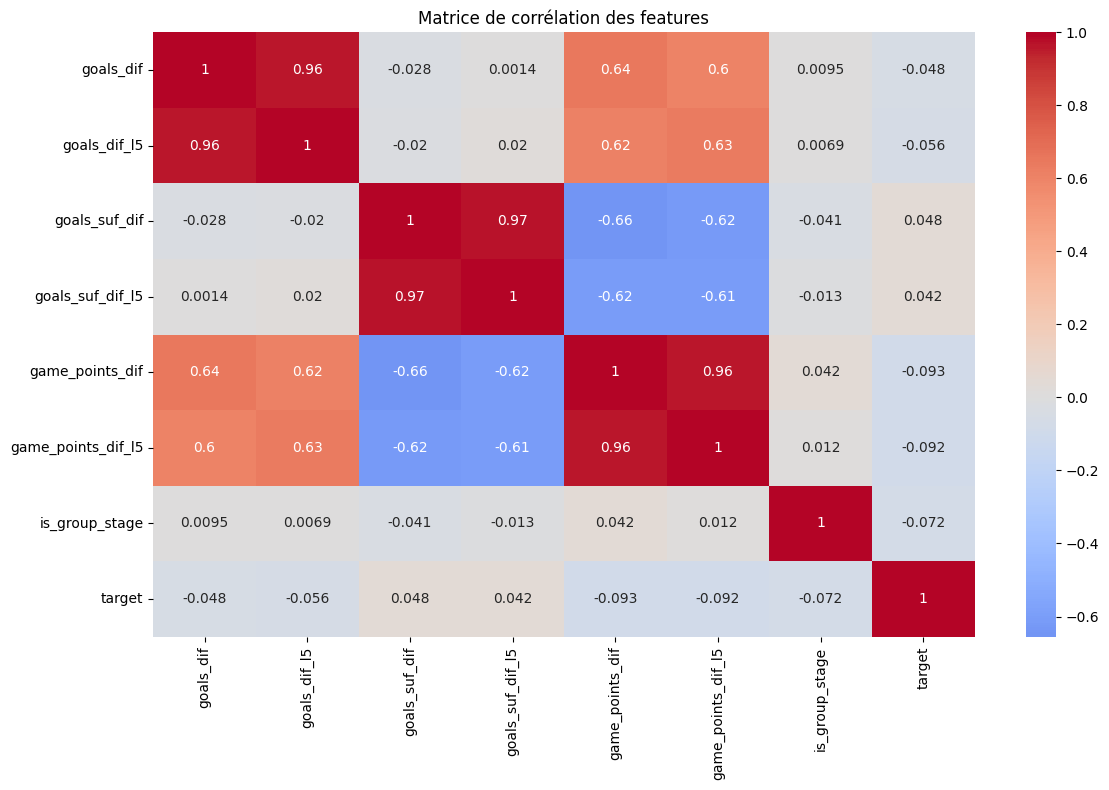

In [17]:
print("\n Analyse des corrélations ")

feature_cols = ['goals_dif', 'goals_dif_l5', 'goals_suf_dif', 'goals_suf_dif_l5',
                'game_points_dif', 'game_points_dif_l5', 'is_group_stage', 'target']

plt.figure(figsize=(12, 8))
sns.heatmap(model_df[feature_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation des features')
plt.tight_layout()
plt.show()

**Préparation des données pour le modèle**

In [18]:
print("\n Préparation pour le ML ")

# Sélectionner les features
feature_columns = ['goals_dif', 'goals_dif_l5', 'goals_suf_dif', 'goals_suf_dif_l5',
                   'game_points_dif', 'game_points_dif_l5', 'is_group_stage']

X = model_df[feature_columns].copy()
y = model_df["target"].copy()

# Vérifier qu'il n'y a pas de NaN
print(f"NaN dans X: {X.isnull().sum().sum()}")
print(f"NaN dans y: {y.isnull().sum()}")

# Vérifier la variance des features
print(f"\nVariance des features:")
for col in feature_columns:
    var = X[col].var()
    print(f"  {col}: {var:.4f}")
    if var < 0.001:
        print(f"     Variance très faible!")

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nDistribution de la target:")
print(y.value_counts())
print(f"Proportion: {y.value_counts(normalize=True)}")

# Afficher quelques lignes pour vérifier
print(f"\n5 premières lignes de X:")
print(X.head())



 Préparation pour le ML 
NaN dans X: 0
NaN dans y: 0

Variance des features:
  goals_dif: 0.4440
  goals_dif_l5: 0.4733
  goals_suf_dif: 0.5847
  goals_suf_dif_l5: 0.6024
  game_points_dif: 0.6490
  game_points_dif_l5: 0.6405
  is_group_stage: 0.2186

Features shape: (349, 7)
Target shape: (349,)

Distribution de la target:
target
0    256
1     93
Name: count, dtype: int64
Proportion: target
0    0.733524
1    0.266476
Name: proportion, dtype: float64

5 premières lignes de X:
   goals_dif  goals_dif_l5  goals_suf_dif  goals_suf_dif_l5  game_points_dif  \
0        0.0           0.0            0.0               0.0              0.0   
1        0.0           0.0            0.0               0.0              0.0   
2        0.0           0.0            0.0               0.0              0.0   
3        0.0           0.0            0.0               0.0              0.0   
4        1.5           1.5           -2.5              -2.5              2.0   

   game_points_dif_l5  is_group_sta

**Split train/test**

In [19]:
if len(X) < 30:
    print("\n ERREUR: Pas assez de données pour entraîner un modèle!")
    print(f"Seulement {len(X)} matches disponibles.")
    print("Conseil: Utilisez plus de données historiques (avant 2015)")
else:
    # Utiliser une stratification pour maintenir la proportion de classes
    from sklearn.model_selection import train_test_split
    
    test_size = 0.2 if len(X) > 100 else 0.3
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"\n Split effectué (test_size={test_size})")
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"Distribution train: {y_train.value_counts().to_dict()}")
    print(f"Distribution test: {y_test.value_counts().to_dict()}")



 Split effectué (test_size=0.2)
Train: (279, 7), Test: (70, 7)
Distribution train: {0: 205, 1: 74}
Distribution test: {0: 51, 1: 19}


**Entraînement du modèle avec GridSearch**

In [20]:
print("\n Entraînement du modèle ")
print("Cela peut prendre quelques minutes...")
    
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
    
gb = GradientBoostingClassifier(random_state=42)
    
# Paramètres adaptés selon la taille du dataset
if len(X_train) < 100:
    params = {
            "learning_rate": [0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth": [3, 5],
            "n_estimators": [50, 100]
    }
    cv_folds = 3
else:
    params = {
            "learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth": [3, 5, 10],
            "max_features": ["sqrt"],
            "n_estimators": [100, 200]
        }
    cv_folds = 5
    
gb_cv = GridSearchCV(gb, params, cv=cv_folds, n_jobs=-1, verbose=1, scoring='roc_auc')
gb_cv.fit(X_train.values, np.ravel(y_train))
    
gb_model = gb_cv.best_estimator_
    
print("\n Modèle entraîné")
print(f"Meilleurs paramètres: {gb_cv.best_params_}")
print(f"Meilleur score CV: {gb_cv.best_score_:.3f}")


 Entraînement du modèle 
Cela peut prendre quelques minutes...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

 Modèle entraîné
Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
Meilleur score CV: 0.618


**Évaluation du modèle**


 Évaluation du modèle 
Train Accuracy: 0.781
Test Accuracy: 0.714


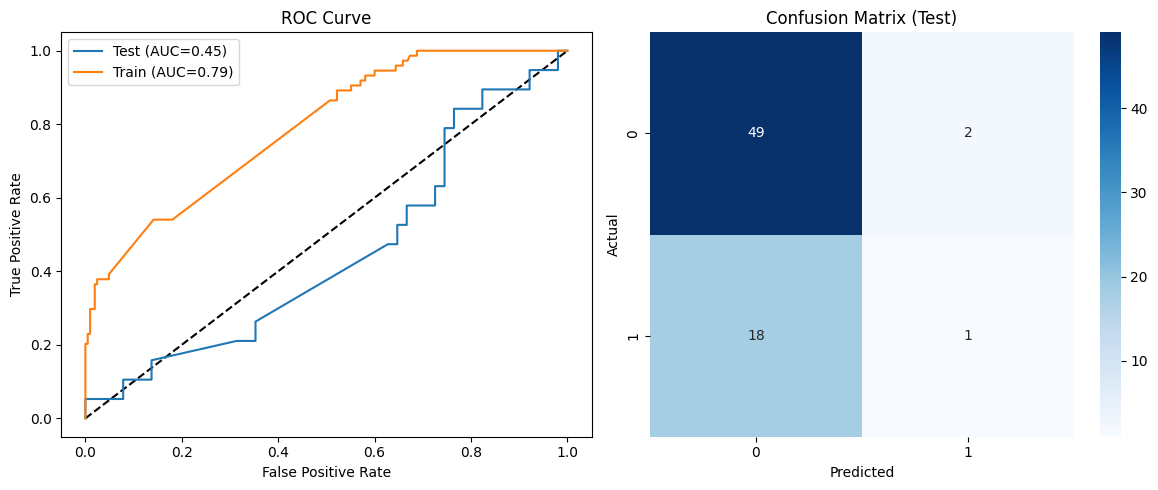


 AUC Test: 0.446, AUC Train: 0.790

 Importance des features 
              feature  importance
0           goals_dif    0.233694
5  game_points_dif_l5    0.174842
1        goals_dif_l5    0.170875
2       goals_suf_dif    0.150317
4     game_points_dif    0.129800
3    goals_suf_dif_l5    0.106345
6      is_group_stage    0.034127


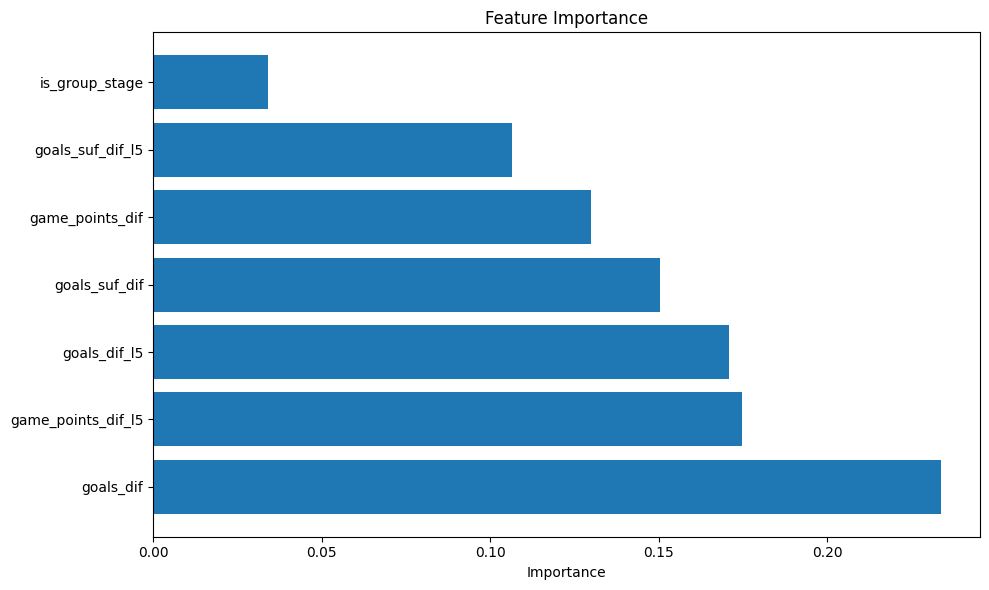

In [21]:
print("\n Évaluation du modèle ")

# Accuracy
train_score = gb_model.score(X_train.values, y_train)
test_score = gb_model.score(X_test.values, y_test)

print(f"Train Accuracy: {train_score:.3f}")
print(f"Test Accuracy: {test_score:.3f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, gb_model.predict_proba(X_test.values)[:,1])
fpr_train, tpr_train, _ = roc_curve(y_train, gb_model.predict_proba(X_train.values)[:,1])

auc_test = roc_auc_score(y_test, gb_model.predict_proba(X_test.values)[:,1])
auc_train = roc_auc_score(y_train, gb_model.predict_proba(X_train.values)[:,1])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f"Test (AUC={auc_test:.2f})")
plt.plot(fpr_train, tpr_train, label=f"Train (AUC={auc_train:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, gb_model.predict(X_test.values))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix (Test)')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

print(f"\n AUC Test: {auc_test:.3f}, AUC Train: {auc_train:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Importance des features ")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

**Fonctions utilitaires pour les prédictions**

In [22]:
print("\n Préparation des fonctions de prédiction ")

def get_team_last_stats(team_name, reference_date=None):
    """
    Récupère les dernières statistiques d'une équipe
    """
    if reference_date is None:
        reference_date = team_stats_full['date'].max()
    
    team_games = team_stats_full[
        (team_stats_full['team'] == team_name) & 
        (team_stats_full['date'] <= reference_date)
    ].sort_values('date', ascending=False)
    
    if len(team_games) == 0:
        # Retourner des stats par défaut si l'équipe n'a pas d'historique
        print(f" Pas d'historique pour {team_name}, utilisation de valeurs par défaut")
        return {
            'goals_mean': 1.2,
            'goals_mean_l5': 1.2,
            'goals_suf_mean': 1.2,
            'goals_suf_mean_l5': 1.2,
            'game_points_mean': 1.5,
            'game_points_mean_l5': 1.5
        }
    
    last5 = team_games.head(5)
    
    return {
        'goals_mean': team_games['score'].mean(),
        'goals_mean_l5': last5['score'].mean() if len(last5) > 0 else team_games['score'].mean(),
        'goals_suf_mean': team_games['suf_score'].mean(),
        'goals_suf_mean_l5': last5['suf_score'].mean() if len(last5) > 0 else team_games['suf_score'].mean(),
        'game_points_mean': team_games['team_points'].mean(),
        'game_points_mean_l5': last5['team_points'].mean() if len(last5) > 0 else team_games['team_points'].mean()
    }

def predict_match(home_team, away_team, is_group=True, model=None):
    """
    Prédit le résultat d'un match
    """
    if model is None:
        print(" Modèle non fourni!")
        return {
            'home_win_prob': 0.5,
            'away_win_prob': 0.5,
            'predicted_winner': home_team,
            'confidence': 0.5
        }
    
    home_stats = get_team_last_stats(home_team)
    away_stats = get_team_last_stats(away_team)
    
    features = {
        'goals_dif': home_stats['goals_mean'] - away_stats['goals_mean'],
        'goals_dif_l5': home_stats['goals_mean_l5'] - away_stats['goals_mean_l5'],
        'goals_suf_dif': home_stats['goals_suf_mean'] - away_stats['goals_suf_mean'],
        'goals_suf_dif_l5': home_stats['goals_suf_mean_l5'] - away_stats['goals_suf_mean_l5'],
        'game_points_dif': home_stats['game_points_mean'] - away_stats['game_points_mean'],
        'game_points_dif_l5': home_stats['game_points_mean_l5'] - away_stats['game_points_mean_l5'],
        'is_group_stage': 1 if is_group else 0
    }
    
    X_pred = pd.DataFrame([features])[feature_columns]
    
    try:
        proba = model.predict_proba(X_pred.values)[0]
    except Exception as e:
        print(f" Erreur de prédiction: {e}")
        return {
            'home_win_prob': 0.5,
            'away_win_prob': 0.5,
            'predicted_winner': home_team,
            'confidence': 0.5
        }
    
    # proba[0] = probabilité victoire home (target=0)
    # proba[1] = probabilité victoire away (target=1)
    
    return {
        'home_win_prob': proba[0],
        'away_win_prob': proba[1],
        'predicted_winner': home_team if proba[0] > proba[1] else away_team,
        'confidence': max(proba)
    }

print(" Fonctions de prédiction créées")

# Test rapide avec le modèle
if 'gb_model' in locals():
    print("\n Test de prédiction ")
    # Prendre deux équipes des données
    if len(results_can) > 0:
        test_match = results_can.iloc[0]
        test_home = test_match['home_team']
        test_away = test_match['away_team']
        
        print(f"Test: {test_home} vs {test_away}")
        test_pred = predict_match(test_home, test_away, is_group=True, model=gb_model)
        print(f"Prédiction: {test_pred['predicted_winner']} ({test_pred['confidence']:.1%})")
        print(f"Probabilités: Home {test_pred['home_win_prob']:.1%} - Away {test_pred['away_win_prob']:.1%}")
else:
    print("\n Modèle non encore entraîné")



 Préparation des fonctions de prédiction 
 Fonctions de prédiction créées

 Test de prédiction 
Test: Ghana  vs  Cameroon
Prédiction: Ghana  (62.9%)
Probabilités: Home 62.9% - Away 37.1%


**Configuration de la CAN 2025**

In [23]:
can_2025_groups = {
    'A': ['Maroc', 'Mali', 'Zambie', 'Comores'],
    'B': ['Égypte', 'Afrique du Sud', 'Angola', 'Zimbabwe'],
    'C': ['Nigeria', 'Tunisie', 'Ouganda', 'Tanzanie'],
    'D': ['Sénégal', 'RD Congo', 'Bénin', 'Botswana'],
    'E': ['Algérie', 'Burkina Faso', 'Guinée Équatoriale', 'Soudan'],
    'F': ['Côte d\'Ivoire', 'Cameroun', 'Gabon', 'Mozambique']
}
# NOTE: Vérifiez et ajustez ces groupes selon le tirage officiel du 27 janvier 2025!

print("\n Groupes de la CAN 2025 (21 déc - 18 jan) ")
for group, teams in can_2025_groups.items():
    print(f"\nGroupe {group}:")
    for team in teams:
        print(f"  - {team}")


 Groupes de la CAN 2025 (21 déc - 18 jan) 

Groupe A:
  - Maroc
  - Mali
  - Zambie
  - Comores

Groupe B:
  - Égypte
  - Afrique du Sud
  - Angola
  - Zimbabwe

Groupe C:
  - Nigeria
  - Tunisie
  - Ouganda
  - Tanzanie

Groupe D:
  - Sénégal
  - RD Congo
  - Bénin
  - Botswana

Groupe E:
  - Algérie
  - Burkina Faso
  - Guinée Équatoriale
  - Soudan

Groupe F:
  - Côte d'Ivoire
  - Cameroun
  - Gabon
  - Mozambique


**Générer les matches de poules**

In [24]:
def generate_group_matches(groups):
    """Génère tous les matches de poule"""
    all_matches = []
    
    for group_name, teams in groups.items():
        # Chaque équipe joue contre toutes les autres du groupe
        for i in range(len(teams)):
            for j in range(i+1, len(teams)):
                all_matches.append((group_name, teams[i], teams[j]))
    
    return all_matches

group_matches = generate_group_matches(can_2025_groups)

print(f"\n {len(group_matches)} matches de poule générés")


 36 matches de poule générés


**Simulation de la phase de poules (avec scores aléatoires)**

In [25]:
# IMPORTANT: Vérifier que le modèle existe
if 'gb_model' not in locals():
    print(" ERREUR: Modèle non entraîné! Impossible de simuler.")
    print("Veuillez d'abord exécuter les cellules d'entraînement du modèle.")
else:
    print(f" Utilisation du modèle entraîné")

# Initialiser le tableau des groupes
group_standings = {}
for group_name, teams in can_2025_groups.items():
    group_standings[group_name] = {
        team: {'points': 0, 'scored': 0, 'conceded': 0, 'gd': 0, 'probs': [], 'matches': 0}
        for team in teams
    }

def simulate_score(winner_prob):
    """
    Simule un score réaliste basé sur la probabilité de victoire
    Retourne (buts_gagnant, buts_perdant)
    """
    # Plus la probabilité est élevée, plus l'écart peut être grand
    if winner_prob > 0.70:  # Favori très clair
        winner_goals = np.random.choice([2, 3, 4], p=[0.4, 0.4, 0.2])
        loser_goals = np.random.choice([0, 1], p=[0.6, 0.4])
    elif winner_prob > 0.60:  # Favori modéré
        winner_goals = np.random.choice([1, 2, 3], p=[0.3, 0.5, 0.2])
        loser_goals = np.random.choice([0, 1, 2], p=[0.4, 0.4, 0.2])
    else:  # Match serré
        winner_goals = np.random.choice([1, 2, 3], p=[0.5, 0.4, 0.1])
        loser_goals = np.random.choice([0, 1, 2], p=[0.3, 0.5, 0.2])
    
    return winner_goals, loser_goals

# Simuler chaque match
current_group = ""
for group, home, away in group_matches:
    
    if current_group != group:
        if current_group != "":
            print()
        print(f"\n--- GROUPE {group} ---")
        current_group = group
    
    # Prédire le match avec le modèle
    prediction = predict_match(home, away, is_group=True, model=gb_model)
    
    home_prob = prediction['home_win_prob']
    away_prob = prediction['away_win_prob']
    
    # Utiliser un tirage aléatoire pondéré pour déterminer le résultat
    draw_prob = 0.15  # 15% de chance de match nul
    adjusted_home = home_prob * (1 - draw_prob)
    adjusted_away = away_prob * (1 - draw_prob)
    
    outcome = np.random.choice(['home', 'away', 'draw'], 
                               p=[adjusted_home, adjusted_away, draw_prob])
    
    if outcome == 'draw':
        # Match nul - scores aléatoires
        draw_score = np.random.choice([0, 1, 2], p=[0.2, 0.5, 0.3])
        home_goals, away_goals = draw_score, draw_score
        
        print(f"{home} {home_goals}-{away_goals} {away}: MATCH NUL")
        
        group_standings[group][home]['points'] += 1
        group_standings[group][away]['points'] += 1
        
    elif outcome == 'home':
        # Victoire domicile
        home_goals, away_goals = simulate_score(home_prob)
        
        print(f"{home} {home_goals}-{away_goals} {away}: Victoire {home} ({home_prob:.1%})")
        
        group_standings[group][home]['points'] += 3
        
    else:
        # Victoire extérieur
        away_goals, home_goals = simulate_score(away_prob)
        
        print(f"{home} {home_goals}-{away_goals} {away}: Victoire {away} ({away_prob:.1%})")
        
        group_standings[group][away]['points'] += 3
    
    # Mettre à jour les statistiques
    group_standings[group][home]['scored'] += home_goals
    group_standings[group][home]['conceded'] += away_goals
    group_standings[group][home]['matches'] += 1
    
    group_standings[group][away]['scored'] += away_goals
    group_standings[group][away]['conceded'] += home_goals
    group_standings[group][away]['matches'] += 1
    
    # Enregistrer les probas pour départager si besoin
    group_standings[group][home]['probs'].append(home_prob)
    group_standings[group][away]['probs'].append(away_prob)

# Calculer les différences de buts
for group_name in group_standings:
    for team in group_standings[group_name]:
        stats = group_standings[group_name][team]
        stats['gd'] = stats['scored'] - stats['conceded']
        stats['avg_prob'] = np.mean(stats['probs']) if stats['probs'] else 0


 Utilisation du modèle entraîné

--- GROUPE A ---
 Pas d'historique pour Maroc, utilisation de valeurs par défaut
 Pas d'historique pour Mali, utilisation de valeurs par défaut
Maroc 4-0 Mali: Victoire Maroc (72.7%)
 Pas d'historique pour Maroc, utilisation de valeurs par défaut
 Pas d'historique pour Zambie, utilisation de valeurs par défaut
Maroc 3-1 Zambie: Victoire Maroc (72.7%)
 Pas d'historique pour Maroc, utilisation de valeurs par défaut
 Pas d'historique pour Comores, utilisation de valeurs par défaut
Maroc 2-2 Comores: MATCH NUL
 Pas d'historique pour Mali, utilisation de valeurs par défaut
 Pas d'historique pour Zambie, utilisation de valeurs par défaut
Mali 2-0 Zambie: Victoire Mali (72.7%)
 Pas d'historique pour Mali, utilisation de valeurs par défaut
 Pas d'historique pour Comores, utilisation de valeurs par défaut
Mali 0-2 Comores: Victoire Comores (27.3%)
 Pas d'historique pour Zambie, utilisation de valeurs par défaut
 Pas d'historique pour Comores, utilisation de vale

**Classement des groupes et qualification (règles CAF officielles)**

In [26]:
qualified_teams = []  # 1er et 2ème de chaque groupe
third_place_teams = []  # 3èmes places

for group_name in sorted(can_2025_groups.keys()):
    print(f"GROUPE {group_name}")
    
    # Calculer la différence de buts
    for team in group_standings[group_name]:
        stats = group_standings[group_name][team]
        stats['gd'] = stats['scored'] - stats['conceded']
    
    # Trier selon les critères CAF officiels:
    # 1. Plus grand nombre de points
    # 2. Différence de buts
    # 3. Plus grand nombre de buts marqués
    # 4. Confrontation directe (non implémenté ici pour simplifier)
    # 5. Fair-play / tirage au sort
    standings = sorted(
        group_standings[group_name].items(),
        key=lambda x: (
            x[1]['points'],           # Points
            x[1]['gd'],               # Différence de buts
            x[1]['scored'],           # Buts marqués
            -x[1]['conceded'],        # Buts encaissés (moins = mieux)
            np.mean(x[1]['probs']) if x[1]['probs'] else 0  # Probabilité moyenne
        ),
        reverse=True
    )
    
    print(f"{'Pos':<5} {'Équipe':<20} {'J':<4} {'Pts':<5} {'BP':<5} {'BC':<5} {'Diff':<6}")
    print("-" * 55)
    
    for i, (team, stats) in enumerate(standings, 1):
        print(f"{i:<5} {team:<20} {stats['matches']:<4} {stats['points']:<5} "
              f"{stats['scored']:<5} {stats['conceded']:<5} {stats['gd']:+6}")
        
        if i == 1 or i == 2:
            # 1er et 2ème qualifiés directement
            qualified_teams.append({
                'group': group_name,
                'position': i,
                'team': team,
                'points': stats['points'],
                'gd': stats['gd'],
                'scored': stats['scored'],
                'conceded': stats['conceded']
            })
        elif i == 3:
            # 3ème place (peut se qualifier)
            third_place_teams.append({
                'group': group_name,
                'position': i,
                'team': team,
                'points': stats['points'],
                'gd': stats['gd'],
                'scored': stats['scored'],
                'conceded': stats['conceded']
            })

# Trier les 3èmes places selon les critères CAF officiels:
# 1. Plus grand nombre de points obtenus
# 2. Différence de buts
# 3. Plus grand nombre de buts marqués
# 4. Tirage au sort
third_place_teams_sorted = sorted(
    third_place_teams,
    key=lambda x: (x['points'], x['gd'], x['scored']),
    reverse=True
)

print("CLASSEMENT DES MEILLEURS 3ÈMES PLACES")
print(f"{'Pos':<5} {'Groupe':<8} {'Équipe':<20} {'Pts':<5} {'Diff':<6} {'BP':<5} {'Qualifié':<10}")
print("-" * 65)

for i, team_info in enumerate(third_place_teams_sorted, 1):
    qualified_status = " OUI" if i <= 4 else "✗ Non"
    print(f"{i:<5} {team_info['group']:<8} {team_info['team']:<20} {team_info['points']:<5} "
          f"{team_info['gd']:+6} {team_info['scored']:<5} {qualified_status:<10}")
    
    if i <= 4:
        qualified_teams.append(team_info)

print(f"\n{'='*60}")
print(f" TOTAL: {len(qualified_teams)} équipes qualifiées pour les huitièmes")
print(f"  - 12 équipes: 1er et 2ème de chaque groupe (6 groupes × 2)")
print(f"  - 4 équipes: meilleurs 3èmes places")
print(f"{'='*60}")


GROUPE A
Pos   Équipe               J    Pts   BP    BC    Diff  
-------------------------------------------------------
1     Maroc                3    7     9     3         +6
2     Comores              3    4     4     6         -2
3     Zambie               3    3     5     5         +0
4     Mali                 3    3     2     6         -4
GROUPE B
Pos   Équipe               J    Pts   BP    BC    Diff  
-------------------------------------------------------
1     Afrique du Sud       3    6     4     1         +3
2     Égypte               3    4     3     2         +1
3     Zimbabwe             3    4     2     5         -3
4     Angola               3    3     3     4         -1
GROUPE C
Pos   Équipe               J    Pts   BP    BC    Diff  
-------------------------------------------------------
1     Tunisie              3    7     7     2         +5
2     Ouganda              3    6     4     6         -2
3     Nigeria              3    4     6     4         +2
4     T

**Organisation du tableau des 8èmes de finale**

In [27]:
# Séparer les qualifiés par position
first_place = [t for t in qualified_teams if t['position'] == 1]
second_place = [t for t in qualified_teams if t['position'] == 2]
third_place_qualified = [t for t in qualified_teams if t['position'] == 3]

# Organiser les confrontations (système CAN typique)
# 1A vs 3C/D/E/F, 1B vs 3A/D/E/F, etc.
round_of_16_matchups = []

# Simplification: créer des paires logiques
all_qualified = first_place + second_place + third_place_qualified

# Méthode: 1er de groupe vs 2ème/3ème d'autres groupes
# On va faire des paires en évitant les équipes du même groupe si possible
used_teams = set()

def find_opponent(team_info, available_teams, avoid_group=None):
    """Trouve un adversaire en évitant le même groupe si possible"""
    # Priorité 1: équipe d'un autre groupe
    for opp in available_teams:
        if opp['team'] not in used_teams and opp['group'] != avoid_group:
            return opp
    # Priorité 2: n'importe quelle équipe disponible
    for opp in available_teams:
        if opp['team'] not in used_teams:
            return opp
    return None

# Créer 8 matchs
first_place_sorted = sorted(first_place, key=lambda x: (x['points'], x['gd']), reverse=True)
others = second_place + third_place_qualified
others_sorted = sorted(others, key=lambda x: (x['points'], x['gd']), reverse=False)

for i in range(8):
    if i < len(first_place_sorted):
        team1 = first_place_sorted[i]
        used_teams.add(team1['team'])
        
        team2 = find_opponent(team1, others_sorted, avoid_group=team1['group'])
        if team2:
            used_teams.add(team2['team'])
            round_of_16_matchups.append((team1['team'], team2['team']))

# Si on n'a pas 8 matchs, compléter avec les équipes restantes
remaining = [t for t in all_qualified if t['team'] not in used_teams]
while len(round_of_16_matchups) < 8 and len(remaining) >= 2:
    team1 = remaining.pop(0)
    team2 = remaining.pop(0)
    round_of_16_matchups.append((team1['team'], team2['team']))

print("\nAffrontements des 8èmes de finale:")
print("-" * 60)
for i, (team1, team2) in enumerate(round_of_16_matchups, 1):
    print(f"Match {i}: {team1} vs {team2}")


Affrontements des 8èmes de finale:
------------------------------------------------------------
Match 1: Burkina Faso vs Zambie
Match 2: Maroc vs Zimbabwe
Match 3: Tunisie vs Comores
Match 4: Sénégal vs Égypte
Match 5: Afrique du Sud vs RD Congo
Match 6: Gabon vs Bénin
Match 7: Ouganda vs Algérie
Match 8: Mozambique vs Nigeria


**Simulation des 8èmes de finale (avec scores)**

In [28]:
quarter_finalists = []

def simulate_knockout_match(home, away, model=None):
    """Simule un match à élimination directe avec prolongation/penalties si besoin"""
    if model is None:
        print(f" ERREUR: Modèle non fourni pour {home} vs {away}")
        # Résultat aléatoire par défaut
        return {
            'home_goals': 1,
            'away_goals': 0,
            'winner': home,
            'match_type': "Aléatoire",
            'home_prob': 0.5,
            'away_prob': 0.5
        }
    
    prediction = predict_match(home, away, is_group=False, model=model)
    
    home_prob = prediction['home_win_prob']
    away_prob = prediction['away_win_prob']
    
    # Tirage aléatoire pour le résultat
    result = np.random.random()
    
    if result < home_prob * 0.9:  # Victoire temps réglementaire home
        home_goals, away_goals = simulate_score(home_prob)
        winner = home
        match_type = "Temps réglementaire"
    elif result < (home_prob * 0.9 + away_prob * 0.9):  # Victoire temps réglementaire away
        away_goals, home_goals = simulate_score(away_prob)
        winner = away
        match_type = "Temps réglementaire"
    else:  # Match nul -> prolongation/penalties
        draw_score = np.random.choice([0, 1, 2], p=[0.3, 0.5, 0.2])
        home_goals = draw_score
        away_goals = draw_score
        
        # Prolongation
        if np.random.random() < 0.6:  # 60% chance de but en prolongation
            if home_prob > away_prob:
                home_goals += 1
                winner = home
                match_type = "Prolongation"
            else:
                away_goals += 1
                winner = away
                match_type = "Prolongation"
        else:  # Tirs au but
            winner = home if home_prob > away_prob else away
            match_type = "Tirs au but"
    
    return {
        'home_goals': home_goals,
        'away_goals': away_goals,
        'winner': winner,
        'match_type': match_type,
        'home_prob': home_prob,
        'away_prob': away_prob
    }

for i, (home, away) in enumerate(round_of_16_matchups, 1):
    result = simulate_knockout_match(home, away, model=gb_model)
    
    print(f"Match {i}: {home} vs {away}")
    print(f"Score: {home} {result['home_goals']}-{result['away_goals']} {away}")
    print(f"Vainqueur: {result['winner']} ({result['match_type']})")
    print(f"Probabilités: {home} {result['home_prob']:.1%} - {away} {result['away_prob']:.1%}")
    print()
    
    quarter_finalists.append(result['winner'])

print(f" {len(quarter_finalists)} qualifiés pour les quarts de finale")


 Pas d'historique pour Burkina Faso, utilisation de valeurs par défaut
 Pas d'historique pour Zambie, utilisation de valeurs par défaut
Match 1: Burkina Faso vs Zambie
Score: Burkina Faso 1-2 Zambie
Vainqueur: Burkina Faso (Temps réglementaire)
Probabilités: Burkina Faso 69.8% - Zambie 30.2%

 Pas d'historique pour Maroc, utilisation de valeurs par défaut
 Pas d'historique pour Zimbabwe, utilisation de valeurs par défaut
Match 2: Maroc vs Zimbabwe
Score: Maroc 1-1 Zimbabwe
Vainqueur: Zimbabwe (Temps réglementaire)
Probabilités: Maroc 69.8% - Zimbabwe 30.2%

 Pas d'historique pour Tunisie, utilisation de valeurs par défaut
 Pas d'historique pour Comores, utilisation de valeurs par défaut
Match 3: Tunisie vs Comores
Score: Tunisie 2-1 Comores
Vainqueur: Tunisie (Temps réglementaire)
Probabilités: Tunisie 69.8% - Comores 30.2%

 Pas d'historique pour Sénégal, utilisation de valeurs par défaut
 Pas d'historique pour Égypte, utilisation de valeurs par défaut
Match 4: Sénégal vs Égypte
Score

**Simulation des quarts de finale**

In [29]:
semi_finalists = []

for i in range(0, len(quarter_finalists), 2):
    home, away = quarter_finalists[i], quarter_finalists[i+1]
    result = simulate_knockout_match(home, away, model=gb_model)
    
    print(f"Match {i//2 + 1}: {home} vs {away}")
    print(f"Score: {home} {result['home_goals']}-{result['away_goals']} {away}")
    print(f"Vainqueur: {result['winner']} ({result['match_type']})")
    print(f"Probabilités: {home} {result['home_prob']:.1%} - {away} {result['away_prob']:.1%}")
    print()
    
    semi_finalists.append(result['winner'])

print(f" {len(semi_finalists)} qualifiés pour les demi-finales")


 Pas d'historique pour Burkina Faso, utilisation de valeurs par défaut
 Pas d'historique pour Zimbabwe, utilisation de valeurs par défaut
Match 1: Burkina Faso vs Zimbabwe
Score: Burkina Faso 2-0 Zimbabwe
Vainqueur: Burkina Faso (Temps réglementaire)
Probabilités: Burkina Faso 69.8% - Zimbabwe 30.2%

 Pas d'historique pour Tunisie, utilisation de valeurs par défaut
 Pas d'historique pour Sénégal, utilisation de valeurs par défaut
Match 2: Tunisie vs Sénégal
Score: Tunisie 2-0 Sénégal
Vainqueur: Tunisie (Temps réglementaire)
Probabilités: Tunisie 69.8% - Sénégal 30.2%

 Pas d'historique pour RD Congo, utilisation de valeurs par défaut
 Pas d'historique pour Gabon, utilisation de valeurs par défaut
Match 3: RD Congo vs Gabon
Score: RD Congo 2-0 Gabon
Vainqueur: RD Congo (Temps réglementaire)
Probabilités: RD Congo 69.8% - Gabon 30.2%

 Pas d'historique pour Ouganda, utilisation de valeurs par défaut
 Pas d'historique pour Mozambique, utilisation de valeurs par défaut
Match 4: Ouganda vs 

**Simulation des demi-finales**

In [30]:
finalists = []
third_place_match = []

for i in range(0, len(semi_finalists), 2):
    home, away = semi_finalists[i], semi_finalists[i+1]
    result = simulate_knockout_match(home, away, model=gb_model)
    
    loser = away if result['winner'] == home else home
    
    print(f"Demi-finale {i//2 + 1}: {home} vs {away}")
    print(f"Score: {home} {result['home_goals']}-{result['away_goals']} {away}")
    print(f"Vainqueur: {result['winner']} ({result['match_type']})")
    print(f"Probabilités: {home} {result['home_prob']:.1%} - {away} {result['away_prob']:.1%}")
    print()
    
    finalists.append(result['winner'])
    third_place_match.append(loser)

print(f" Les finalistes sont: {finalists[0]} et {finalists[1]}")

 Pas d'historique pour Burkina Faso, utilisation de valeurs par défaut
 Pas d'historique pour Tunisie, utilisation de valeurs par défaut
Demi-finale 1: Burkina Faso vs Tunisie
Score: Burkina Faso 1-0 Tunisie
Vainqueur: Burkina Faso (Temps réglementaire)
Probabilités: Burkina Faso 69.8% - Tunisie 30.2%

 Pas d'historique pour RD Congo, utilisation de valeurs par défaut
 Pas d'historique pour Mozambique, utilisation de valeurs par défaut
Demi-finale 2: RD Congo vs Mozambique
Score: RD Congo 2-1 Mozambique
Vainqueur: RD Congo (Prolongation)
Probabilités: RD Congo 69.8% - Mozambique 30.2%

 Les finalistes sont: Burkina Faso et RD Congo


**FINALE et Match pour la 3ème place**

In [31]:
print("\n" + "="*60)
print("🥉 MATCH POUR LA 3ÈME PLACE")
print("="*60 + "\n")

home_3rd, away_3rd = third_place_match[0], third_place_match[1]
result_3rd = simulate_knockout_match(home_3rd, away_3rd, model=gb_model)

print(f"{home_3rd} vs {away_3rd}")
print(f"Score: {home_3rd} {result_3rd['home_goals']}-{result_3rd['away_goals']} {away_3rd}")
print(f"3ème place: {result_3rd['winner']} ({result_3rd['match_type']})")

third_place = result_3rd['winner']
fourth_place = away_3rd if third_place == home_3rd else home_3rd

print("\n" + "="*60)
print("🏆 FINALE DE LA CAN 2025")
print("="*60 + "\n")

home_final, away_final = finalists[0], finalists[1]
result_final = simulate_knockout_match(home_final, away_final, model=gb_model)

print(f"🎯 {home_final} vs {away_final}")
print(f"📊 Score: {home_final} {result_final['home_goals']}-{result_final['away_goals']} {away_final}")
print(f"⚽ Vainqueur: {result_final['winner']} ({result_final['match_type']})")
print(f"📈 Probabilités: {home_final} {result_final['home_prob']:.1%} - {away_final} {result_final['away_prob']:.1%}")

champion = result_final['winner']
runner_up = away_final if champion == home_final else home_final

print("\n" + "="*60)
print("🏆 PODIUM DE LA CAN 2025 🏆")
print("="*60)
print(f"\n🥇 CHAMPION: {champion}")
print(f"🥈 Vice-champion: {runner_up}")
print(f"🥉 3ème place: {third_place}")
print(f"   4ème place: {fourth_place}")
print("\n" + "="*60)
print(f"🎊 Le modèle prédit que {champion} remportera la CAN 2025! 🎊")
print("="*60)

# Résumé des statistiques
print("\n" + "="*60)
print("📊 STATISTIQUES DE LA SIMULATION")
print("="*60)
print(f"• Total de matches simulés: {len(group_matches) + 8 + 4 + 2 + 2}")
print(f"• Matches de poule: {len(group_matches)}")
print(f"• Matches à élimination directe: 16 (8èmes + quarts + demi + finale + 3ème place)")
print(f"• Équipes participantes: {len(can_2025_groups) * 4}")
print(f"• Équipes qualifiées pour les 8èmes: 16")
print("="*60)


🥉 MATCH POUR LA 3ÈME PLACE

 Pas d'historique pour Tunisie, utilisation de valeurs par défaut
 Pas d'historique pour Mozambique, utilisation de valeurs par défaut
Tunisie vs Mozambique
Score: Tunisie 3-2 Mozambique
3ème place: Tunisie (Prolongation)

🏆 FINALE DE LA CAN 2025

 Pas d'historique pour Burkina Faso, utilisation de valeurs par défaut
 Pas d'historique pour RD Congo, utilisation de valeurs par défaut
🎯 Burkina Faso vs RD Congo
📊 Score: Burkina Faso 1-1 RD Congo
⚽ Vainqueur: Burkina Faso (Temps réglementaire)
📈 Probabilités: Burkina Faso 69.8% - RD Congo 30.2%

🏆 PODIUM DE LA CAN 2025 🏆

🥇 CHAMPION: Burkina Faso
🥈 Vice-champion: RD Congo
🥉 3ème place: Tunisie
   4ème place: Mozambique

🎊 Le modèle prédit que Burkina Faso remportera la CAN 2025! 🎊

📊 STATISTIQUES DE LA SIMULATION
• Total de matches simulés: 52
• Matches de poule: 36
• Matches à élimination directe: 16 (8èmes + quarts + demi + finale + 3ème place)
• Équipes participantes: 24
• Équipes qualifiées pour les 8èmes:

In [32]:
# Créer un dossier pour sauvegarder les modèles si nécessaire
model_dir = os.path.join(os.path.dirname(os.path.abspath('.')), 'models')
os.makedirs(model_dir, exist_ok=True)

# Sauvegarder le modèle entraîné
model_path = os.path.join(model_dir, 'gb_model_can_2025.joblib')
joblib.dump(gb_model, model_path)

print(f"Modèle sauvegardé avec succès: {model_path}")
print(f"Informations du modèle:")
print(f"- Taille du fichier: {os.path.getsize(model_path) / 1024:.2f} KB")
print(f"- Meilleurs paramètres: {gb_cv.best_params_}")
print(f"- Score CV: {gb_cv.best_score_:.3f}")

# Sauvegarder également les noms des features pour la prédiction future
feature_names_path = os.path.join(model_dir, 'feature_columns.joblib')
joblib.dump(feature_columns, feature_names_path)
print(f"Noms des features sauvegardés: {feature_names_path}")

Modèle sauvegardé avec succès: c:\Users\Dell\Desktop\models\gb_model_can_2025.joblib
Informations du modèle:
- Taille du fichier: 220.80 KB
- Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
- Score CV: 0.618
Noms des features sauvegardés: c:\Users\Dell\Desktop\models\feature_columns.joblib


In [33]:
# Pour charger le modèle sauvegardé dans une future session:
import joblib

model_path = 'models/gb_model_can_2025.joblib'
gb_model = joblib.load(model_path)
feature_columns = joblib.load('models/feature_columns.joblib')

print("Modèle chargé avec succès!")
print(f"Features disponibles: {feature_columns}")

Modèle chargé avec succès!
Features disponibles: ['goals_dif', 'goals_dif_l5', 'goals_suf_dif', 'goals_suf_dif_l5', 'game_points_dif', 'game_points_dif_l5', 'is_group_stage']
